In [ ]:
!pip3 install numpy opencv-python matplotlib scikit-learn pandas requests kagglehub

In [ ]:
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Read face image from zip file
faces = dict()
with zipfile.ZipFile("../assets/40_people_faces.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # we use OpenCV to decode the byte string into an array of pixels
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

File naming ex1: s1/1.pgm
File naming ex2: s1/10.pgm
File naming ex3: s1/2.pgm


Showing sample faces


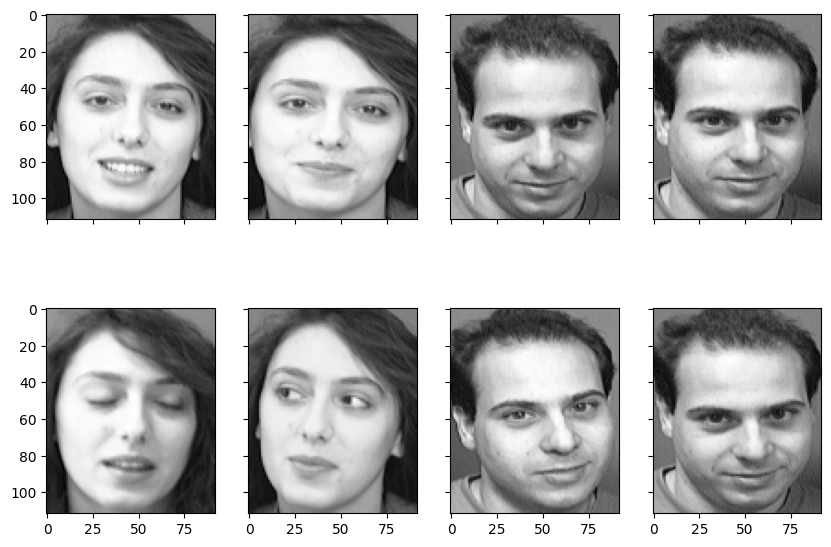

Face image shape: (112, 92)


In [ ]:
# Show sample faces using matplotlib
img_number = 8
offset = 6

# showing the structure of the files
print("File naming ex1:", list(faces.keys())[0])
print("File naming ex2:", list(faces.keys())[1])
print("File naming ex3:", list(faces.keys())[2])
print('\n')

fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,7))
# take last N of images
face_images = list(faces.values())[-img_number-offset:-offset]

for i in range(img_number):
    axes[i%2][i//2].imshow(face_images[i], cmap="gray")
print("Showing sample faces")
plt.show()

# Print the pixel size of each picture
face_shape = list(faces.values())[0].shape
print("Face image shape:", face_shape)

In [72]:
# Separate images of 1-39 person and  eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
face_matrix = list()
person_face_label = list()
for key, val in faces.items():
    if key.startswith("s1/"):
        continue # this is our test set
    if key == "s28/10.pgm":
        continue # this is our test set
    face_matrix.append(val.flatten()) # save the images
    person_face_label.append(key.split("/")[0]) # save only the person number

# Create a NxM matrix with N images and M pixels per image
face_matrix = np.array(face_matrix)

Showing the eigenfaces


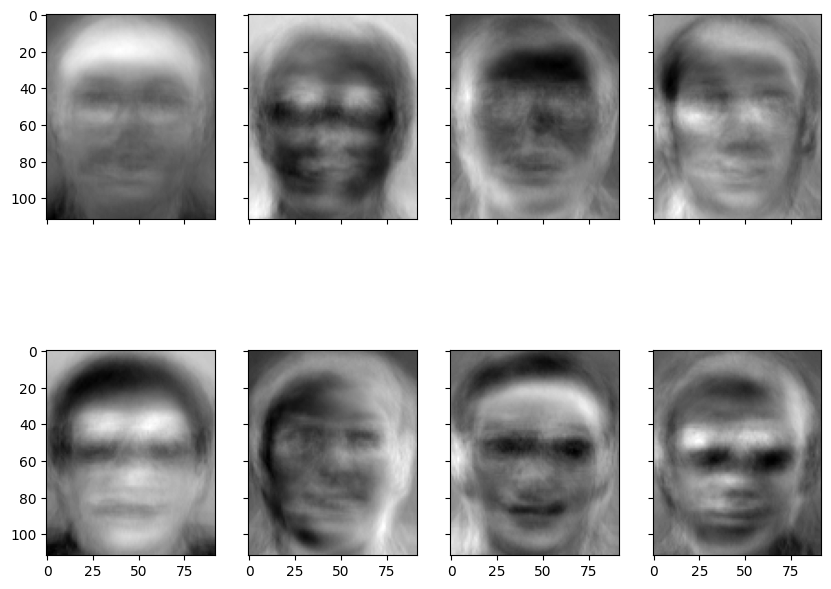

In [73]:
# Apply PCA, where each row represent an eigenvector/eigenface
pca = PCA().fit(face_matrix)

# taking the first 50 eigenvectors (PC) with the highest eigenvalues
n_components = 50
eigenfaces = pca.components_[:n_components]

# Show the first 8 eigenfaces/eigenvectors
fig, axes = plt.subplots(2,4,sharex=True,sharey=True,figsize=(10,8))
for i in range(img_number):
    axes[i%(img_number//4)][i//(img_number//4)].imshow(
      eigenfaces[i].reshape(face_shape),
      cmap="gray")

print("Showing the eigenfaces")
plt.show()

In [74]:
# printing the variance matrix (eigenvalues of each eigenvectors/principal component)
print(pca.explained_variance_ratio_)

[1.70780740e-01 1.32517676e-01 6.97363875e-02 5.30704486e-02
 5.06933404e-02 3.39107987e-02 2.48833016e-02 2.37515470e-02
 2.00623037e-02 1.78298065e-02 1.47541861e-02 1.42750095e-02
 1.11661379e-02 1.07642830e-02 9.97889157e-03 9.30647249e-03
 8.74503347e-03 8.43829484e-03 7.30199790e-03 7.05815388e-03
 6.56929737e-03 6.34580027e-03 5.99177147e-03 5.48821457e-03
 5.42668797e-03 5.06664515e-03 4.87539708e-03 4.65286898e-03
 4.54239679e-03 4.44783543e-03 4.42209795e-03 4.08903892e-03
 3.98669059e-03 3.77894694e-03 3.63800120e-03 3.53331156e-03
 3.47359713e-03 3.35565642e-03 3.24812808e-03 3.04874959e-03
 2.99400611e-03 2.93304559e-03 2.85104369e-03 2.74431755e-03
 2.69471166e-03 2.63238684e-03 2.57459435e-03 2.52001311e-03
 2.48062656e-03 2.39183484e-03 2.33155085e-03 2.22796718e-03
 2.21116947e-03 2.15094495e-03 2.12450132e-03 2.06290604e-03
 2.02767283e-03 1.98588418e-03 1.96958397e-03 1.92635545e-03
 1.86320415e-03 1.83633334e-03 1.74251700e-03 1.71414963e-03
 1.70663333e-03 1.665756

In [75]:
# calculate the weight vector for each input picture and save it in
# 'weights' as a KxN matrix, where K is the number of eigenfaces and N
# the number of samples
weights = eigenfaces @ (face_matrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

Shape of the weight matrix: (50, 389)


Best match s28 with Euclidean distance 1907.380103


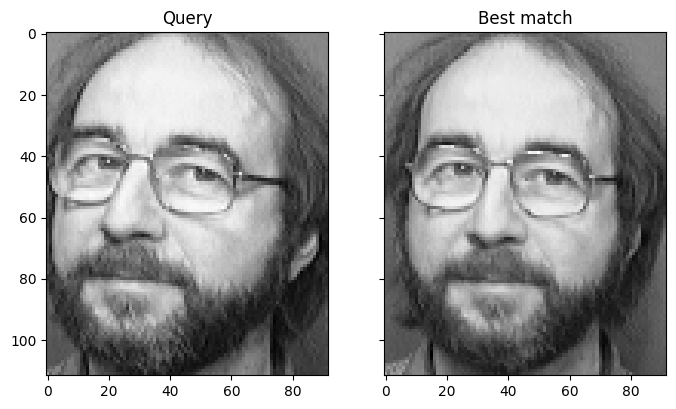

In [76]:
# Test on out-of-sample image of existing class
query = faces["s28/10.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Best match s13 with Euclidean distance 3645.429132


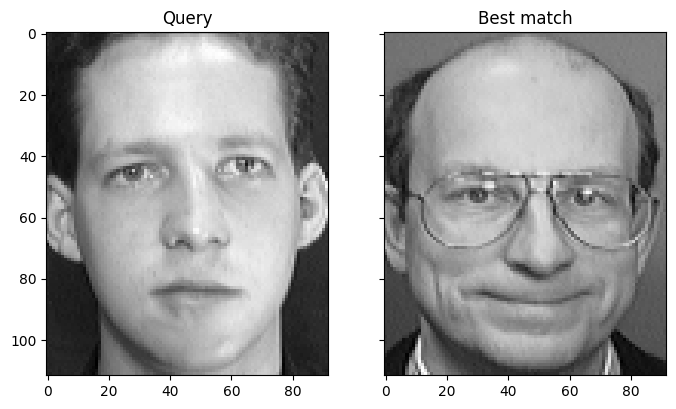

In [81]:
# Test on out-of-sample image of new class
query = faces["s1/8.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (person_face_label[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(face_shape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(face_matrix[best_match].reshape(face_shape), cmap="gray")
axes[1].set_title("Best match")
plt.show()